# **Introduction**
Mosquito-borne diseases, such as malaria, dengue, and Zika, pose significant public health threats globally, affecting millions of individuals annually—especially in tropical regions. Effective mosquito species identification is crucial for implementing timely vector control measures and preventing outbreaks. Traditionally, species identification relies on human expertise in entomology, which is both time-consuming and prone to human error.

Recent advances in computer vision and deep learning have revolutionized image recognition, offering automated and highly accurate solutions for tasks such as species classification. Leveraging these technologies, researchers are developing machine learning frameworks to classify mosquitoes from images—particularly those captured on human skin—for real-time vector identification and control.

In this project, a **custom three-layer Convolutional Neural Network (CNN)** model is developed to classify six different mosquito classes with the goal of supporting accurate and efficient species identification for improved disease prevention.

**The code implementation consists of 6 steps:**


1.   Initial Setup
2.   Exploratory Analysis of Data
3.   Model Design
4.   Training, Validating and Tesing
5.   Results visualization
6.   Discussion









# **Motivation**
Accurately identifying mosquito species is challenging because of subtle visual differences, which can be difficult for humans to distinguish. Traditional methods like measuring wing-flapping frequency are limited and not scalable. As image classification continues to improve through deep learning, there is growing potential to develop automated systems that assist in mosquito species recognition, ultimately contributing to better disease prevention.

# **Problem Statement**
Mosquitoes pose substantial threat to public health resulting in million number of deaths worldwide every year. They act as the vectors responsible for diseases. The
harmful mosquito species are contained in the genera Aedes, Anopheles and Culex. Since the differences between
species are trivial for human vision, the current prevailing approach for identifying mosquito's species is based on
recording the frequency of wing flapping, image classification of mosquitos is still a developing problem that requiring
contributions.

# **Data Source**
The dataset used in this project consists of **RGB images of mosquitoes**, specifically collected for training and evaluating recognition systems that identify mosquitoes on human skin. The images were sourced from a **WHO-accredited breeding laboratory** in 2022, ensuring accurate species labeling and reliable annotations. The dataset includes **three mosquito species** which are ***Aedes aegypti, Aedes albopictus, and Culex quinquefasciatus*** and each captured in two physical conditions: ***normal landing and smashed***. This results in a total of six well-defined classes, making the dataset highly suitable for supervised learning tasks.

# **Code Implementation**

## **STEP1: Initial Setup**

In [1]:
# The dataset is stored in google drive, this step is to connect notebook to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import defaultdict, Counter
from PIL import Image, ImageEnhance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import warnings
import os
warnings.filterwarnings('ignore')


In [3]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)        # Fix PyTorch random seed (CPU operations)
np.random.seed(42)           # Fix NumPy random seed

# If using GPU, set CUDA-specific seeds and make operations deterministic
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)                  # Fix PyTorch random seed on GPU
    torch.backends.cudnn.deterministic = True   # Use deterministic algorithms (same results every run)
    torch.backends.cudnn.benchmark = False      # Disable autotuner (can introduce randomness)

# Set device: use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print GPU name if using CUDA
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: Tesla T4


## Create a directory in Google Drive which contains the best model to classify


### This helps get the test accuracy quickly without having to run the training process again

In [5]:
# create dir to save the best model
MODEL_SAVE_DIR = "/content/drive/MyDrive/Mosquito-dataset/models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_SAVE_DIR, "best_model.pt")

print(f"Save modal to: {MODEL_PATH}")


Save modal to: /content/drive/MyDrive/Mosquito-dataset/models/best_model.pt


In [6]:
%cd /content/drive/MyDrive/Mosquito-dataset

/content/drive/MyDrive/Mosquito-dataset




---



## **STEP2: Exploratory Analysis of Data**

## Class Transform - Preporcessing
This is a custom transformation class that dynamically builds different image pipelines depending on whether we are in training or validation/testing mode.

***If it's training dataset,*** it applies data augmentation to help generalize the model. It helps make model **more robust to real word variation** and **prevent overfitting** by exposing the model to slightly different versions of the same image.



***Otherwise,*** it applies consistent preprocessing to test/validation data. Ensures **deterministic, fair evaluation (no randomness)**.



In [7]:
class Transform:
    def __init__(self, training=True):
        self.training = training

    def __call__(self, image):
        if self.training:
            augment_pipeline = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
            ])
        else:
            augment_pipeline = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        return augment_pipeline(image)


# Create transforms
train_transform = Transform(training=True)
val_test_transform = Transform(training=False)

## Display the sample of input images

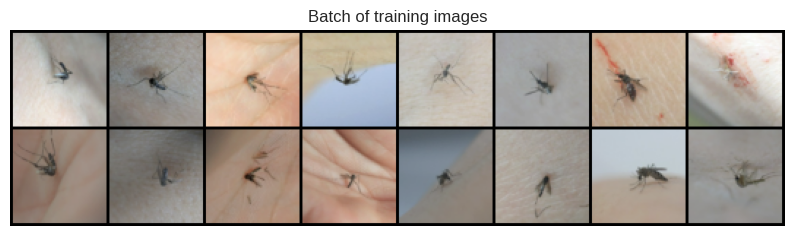

In [10]:
import matplotlib.pyplot as plt
import torchvision

# Get one batch
images, labels = next(iter(trainloader))

# Make a grid (8 images per row)
img_grid = torchvision.utils.make_grid(images[:16], nrow=8, padding=2)

# Convert from torch tensor to numpy and plot
plt.figure(figsize=(10, 5))
plt.imshow(img_grid.permute(1, 2, 0))  # Change from [C,H,W] to [H,W,C]
plt.axis('off')
plt.title("Batch of training images")
plt.show()

# Dataset analysis

This function is designed to inspect and summarize a dataset that's organized in a folder structure.

In [8]:
# Dataset analysis function
def analyze_dataset(dataset_path, transform=None):
    dataset = datasets.ImageFolder(dataset_path, transform=transform)

    # Count samples per class
    class_counts = Counter([dataset.classes[label] for _, label in dataset.samples])

    print(f"Dataset: {dataset_path.split('/')[-1]}")
    print(f"Total samples: {len(dataset)}")
    print(f"Classes: {len(dataset.classes)}")
    print("\n Class distribution:")

    for class_name, count in class_counts.items():
        percentage = (count / len(dataset)) * 100
        print(f"   {class_name}: {count} samples ({percentage:.1f}%)")

    return dataset, class_counts


In [9]:
# Dataset paths
train_path = "/content/drive/MyDrive/Mosquito-dataset/data_splitting/Train"
pred_path = "/content/drive/MyDrive/Mosquito-dataset/data_splitting/Pred"
test_path = "/content/drive/MyDrive/Mosquito-dataset/data_splitting/Test"

# Analyze datasets using the analyze_dataset function
trainset, train_counts = analyze_dataset(train_path)
print("\n" + "="*50 + "\n")

testset, test_counts = analyze_dataset(test_path)
print("\n" + "="*50 + "\n")

predset, pred_counts = analyze_dataset(pred_path)
print("\n" + "="*50 + "\n")

# Reload datasets with appropriate transforms
trainset = datasets.ImageFolder(train_path, transform=train_transform)
testset = datasets.ImageFolder(test_path, transform=val_test_transform)
predset = datasets.ImageFolder(pred_path, transform=val_test_transform)

# Create DataLoaders with smaller batch size for better stability (avoid memory issues)
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
predloader = DataLoader(predset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)


Dataset: Train
Total samples: 4200
Classes: 6

 Class distribution:
   Culex landing: 700 samples (16.7%)
   Culex smashed: 700 samples (16.7%)
   aegypti landing: 700 samples (16.7%)
   aegypti smashed: 700 samples (16.7%)
   albopictus landing: 700 samples (16.7%)
   albopictus smashed: 700 samples (16.7%)


Dataset: Test
Total samples: 1799
Classes: 6

 Class distribution:
   Culex landing: 300 samples (16.7%)
   Culex smashed: 300 samples (16.7%)
   aegypti landing: 300 samples (16.7%)
   aegypti smashed: 300 samples (16.7%)
   albopictus landing: 299 samples (16.6%)
   albopictus smashed: 300 samples (16.7%)


Dataset: Pred
Total samples: 3600
Classes: 6

 Class distribution:
   Culex landing: 600 samples (16.7%)
   Culex smashed: 600 samples (16.7%)
   aegypti landing: 600 samples (16.7%)
   aegypti smashed: 600 samples (16.7%)
   albopictus landing: 600 samples (16.7%)
   albopictus smashed: 600 samples (16.7%)




### **From the above output we can observe:**
The dataset is divided into **training, testing, and prediction** subsets, each containing RGB images labeled into **six distinct classes**. These classes are based on combinations of three mosquito species (Aedes aegypti, Aedes albopictus, and Culex quinquefasciatus) and two physical conditions (landing and smashed):


*   Culex landing
*   Culex smashed
*   Aedes aegypti landing
*   Aedes aegypti smashed
*   Aedes albopictus landing
*   Aedes albopictus smashed

Each image is in RGB format, with a standardized resolution of 64x64 pixels.


All subsets are **evenly distributed** across the six classes, ensuring balanced training and fair evaluation. The only minor exception is Aedes albopictus landing in the test set, which has 299 samples.

However, challenges related to subtle visual differences and real-world image variation make this a non-trivial classification task.



---



## **STEP3: Model Design**
It consists of **three convolutional blocks**, each followed by batch normalization, ReLU activation, and max pooling to reduce spatial dimensions. These layers extract increasingly complex features from the input images. After the final convolutional block, the feature maps are flattened and passed through a fully connected layer with dropout to prevent overfitting, followed by an output layer that predicts class logits. The model assumes input images of size 64x64x3 and outputs predictions for the specified number of classes.

In [29]:
class MosquitoCNN(nn.Module):
    def __init__(self, num_classes):
        super(MosquitoCNN, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial size by half

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layers (assumes input image size 64x64)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv Block 1: [B, 3, 64, 64] → [B, 32, 32, 32]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Conv Block 2: [B, 32, 32, 32] → [B, 64, 16, 16]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Conv Block 3: [B, 64, 16, 16] → [B, 128, 8, 8]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten: [B, 128, 8, 8] → [B, 8192]
        x = x.view(x.size(0), -1)

        # FC + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Output logits
        x = self.fc2(x)
        return x



## Quick test for the model
Quickly test if the CNN model works correctly with the dataset and training setup before running a full training loop

In [25]:
print("Testing model with one batch...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(trainset.classes)

# Create a test model
test_model = MosquitoCNN(num_classes=num_classes)
test_model = test_model.to(device)

# Get one batch for testing
try:
    images, labels = next(iter(trainloader))
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass test
    with torch.no_grad():
        outputs = test_model(images)
        print(f"Output shape: {outputs.shape}")
        print("Model forward pass successful!")

    # Test one training step
    test_model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.001)

    optimizer.zero_grad()
    outputs = test_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f"Training step successful! Loss: {loss.item():.4f}")

except Exception as e:
    print(f"Error occurred: {e}")
    print("Please check your data paths and model architecture")


Testing model with one batch...
Batch shape: torch.Size([64, 3, 64, 64]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 6])
Model forward pass successful!
Training step successful! Loss: 1.7979


## Model Training Fuctions and Evaluation Functions
### **fit() Function**


The fit() function handles the training and validation of the CNN model:

**Training loop:** Iterates through batches of training data, performs forward pass, computes loss, backpropagates gradients, and updates model weights using the optimizer.

**Validation loop:** After each epoch, evaluates the model on the validation set without updating weights.

**Progress tracking:** Prints training/validation loss at regular intervals.

**Best model saving:** Saves the model (MODEL_PATH) whenever a new lowest validation loss is achieved.

**Returns:**

*   train_loss_record: List of training loss per epoch
*   val_loss_record: List of validation loss per epoch


### **evaluate() Function**
Evaluates the trained model on the test set:

Computes the number of correct predictions vs. total samples.

Returns overall test accuracy.




In [18]:
def fit(model, trainloader, valloader, criterion, optimizer, num_epochs=10, device='cpu'):
    train_loss_record = []
    val_loss_record = []

    model.to(device)
    best_val_loss = float('inf')

    print(f"🚀 Starting training for {num_epochs} epochs...")
    print(f"📊 Number of training batches: {len(trainloader)}")
    print(f"📊 Number of validation batches: {len(valloader)}")
    print(f"🎯 Device in use: {device}")
    print("=" * 60)

    for epoch in range(num_epochs):
        print(f"🔄 Epoch {epoch+1}/{num_epochs} starting...")

        model.train()
        running_train_loss = 0.0
        train_batches = 0

        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
            train_batches += 1

            # Print progress every 20 batches
            if (batch_idx + 1) % 20 == 0:
                current_loss = running_train_loss / (train_batches * images.size(0))
                print(f"  📈 Batch {batch_idx+1}/{len(trainloader)} - Loss: {current_loss:.4f}")

        epoch_train_loss = running_train_loss / len(trainloader.dataset)
        train_loss_record.append(epoch_train_loss)
        print(f"  ✅ Training complete - Average Loss: {epoch_train_loss:.4f}")

        # Validation
        print(f"  🔍 Starting validation...")
        model.eval()
        running_val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                val_batches += 1

                # Print progress every 30 batches
                if (batch_idx + 1) % 30 == 0:
                    current_val_loss = running_val_loss / (val_batches * images.size(0))
                    print(f"    📊 Validation Batch {batch_idx+1}/{len(valloader)} - Loss: {current_val_loss:.4f}")

        epoch_val_loss = running_val_loss / len(valloader.dataset)
        val_loss_record.append(epoch_val_loss)

        print(f"🎯 Epoch [{epoch+1}/{num_epochs}] finished!")
        print(f" Training Loss: {epoch_train_loss:.4f}")
        print(f" Validation Loss: {epoch_val_loss:.4f}")

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), MODEL_PATH)
            print(f" 💾 New best model saved to {MODEL_PATH}!")

        print("-" * 60)

    print("✅ Training finished!")
    return train_loss_record, val_loss_record


def evaluate(model, testloader, device='cpu'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")
    return acc


In [14]:
def test(model, testloader, criterion, device='cpu'):
    """
    Test function: collects prediction results, true labels, and correctly classified sample images.
    """
    model.eval()
    model.to(device)

    all_predictions = []
    all_labels = []
    correct_images = {}

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Save one correctly classified image per class
            for i in range(len(labels)):
                if predicted[i] == labels[i]:  # Correct classification
                    label_idx = labels[i].item()
                    if label_idx not in correct_images:
                        correct_images[label_idx] = (images[i].cpu(), testset.classes[label_idx])



    # Calculate overall accuracy
    total_accuracy = sum(1 for p, l in zip(all_predictions, all_labels) if p == l) / len(all_labels)
    print(f"Overall test accuracy: {total_accuracy:.4f}")

    return correct_images, all_labels, all_predictions


## Functions for Visualizing the Results

**plot_correct_images():** Displays one correctly classified image per class from the test set. Useful for visual debugging and understanding model behavior.

**plot_confusion_matrix():**  Plots the confusion matrix to evaluate overall classification performance, showing how often predictions match actual labels — and where the model may confuse classes.

**calculate_per_class_accuracy():** Calculates and displays the accuracy for each individual class, helping identify which classes are well-learned and which need improvement.





In [21]:
def plot_correct_images(correct_images, class_names=None):
    """
    Display one correctly classified image for each class.
    """
    if not correct_images:
        print("❌ No correctly classified samples found.")
        return

    print(f"🖼️ Displaying correctly classified samples ({len(correct_images)} classes)")

    # Calculate subplot layout
    num_images = len(correct_images)
    cols = min(4, num_images)  # Max 4 columns
    rows = (num_images + cols - 1) // cols  # Compute required rows

    plt.figure(figsize=(15, 4 * rows), dpi=150)

    for i, (label_idx, (img, label_name)) in enumerate(correct_images.items()):
        img = img.unsqueeze(0)  # Add batch dimension
        img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
        img = img.squeeze(0)  # Remove batch dimension
        img = img.permute(1, 2, 0)  # Convert [C,H,W] → [H,W,C] for Matplotlib

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {label_name}", fontsize=12, fontweight='bold')
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [22]:
def plot_confusion_matrix(all_labels, all_predictions, class_names):
    """
    Plot the confusion matrix to evaluate classification performance.
    """
    print("Generating Confusion Matrix...")

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm


In [23]:
def calculate_per_class_accuracy(all_labels, all_predictions, class_names):
    """
    Calculate and display accuracy for each class.
    """
    print("📈 Calculating per-class accuracy...")

    cm = confusion_matrix(all_labels, all_predictions)

    per_class_accuracy = {}
    for i in range(len(class_names)):
        if cm[i, :].sum() > 0:
            accuracy = cm[i, i] / cm[i, :].sum()
            per_class_accuracy[class_names[i]] = accuracy
        else:
            per_class_accuracy[class_names[i]] = 0.0

    # Print results
    print("\n📊 Accuracy per class:")
    print("=" * 50)
    for class_name, accuracy in per_class_accuracy.items():
        print(f"  {class_name}: {accuracy:.4f} ({accuracy*100:.1f}%)")

    # Bar plot
    plt.figure(figsize=(12, 6))
    classes = list(per_class_accuracy.keys())
    accuracies = list(per_class_accuracy.values())

    bars = plt.bar(classes, accuracies, color='skyblue', alpha=0.7)
    plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)

    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    return per_class_accuracy



## **STEP4: Training, Validating and Tesing**

In [ ]:
#Training and testing

print("Preparing for training...")

# # Test dataloaders
try:
    train_images, train_labels = next(iter(trainloader))
    print(f"Training data loaded successfully: {train_images.shape}")

    test_images, test_labels = next(iter(predloader))
    print(f"Validation data loaded successfully: {test_images.shape}")

except Exception as e:
    print(f"Data loading error:  {e}")

print(f"Number of classes: {num_classes}")
print(f"Class labels: {trainset.classes}")

model = MosquitoCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("🚀 Starting training using fit()...")
train_loss_record, val_loss_record = fit(model, trainloader, predloader, criterion, optimizer, num_epochs=60, device=device)

print("✅ Training completed!")


Preparing for training...
Training data loaded successfully: torch.Size([64, 3, 64, 64])
Validation data loaded successfully: torch.Size([64, 3, 64, 64])
Number of classes: 6
Class labels: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']
🚀 Starting training using fit()...
🚀 Starting training for 60 epochs...
📊 Number of training batches: 66
📊 Number of validation batches: 57
🎯 Device in use: cuda
🔄 Epoch 1/60 starting...
  📈 Batch 20/66 - Loss: 2.2871
  📈 Batch 40/66 - Loss: 1.9971
  📈 Batch 60/66 - Loss: 1.9072
  ✅ Training complete - Average Loss: 1.8889
  🔍 Starting validation...
    📊 Validation Batch 30/57 - Loss: 1.9216
🎯 Epoch [1/60] finished!
 Training Loss: 1.8889
 Validation Loss: 1.8148
 💾 New best model saved to /content/drive/MyDrive/Mosquito-dataset/models/best_model.pt!
------------------------------------------------------------
🔄 Epoch 2/60 starting...
  📈 Batch 20/66 - Loss: 1.6858
  📈 Batch 40/66 - L

In [ ]:
# Load best model and get test accuracy
# model.load_state_dict(torch.load(MODEL_PATH))
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
evaluate(model, testloader, device=device)

Test Accuracy: 0.8054


0.8054474708171206

##Test the Model
## After testing the model with the test dataset, we observed that the final accuracy reached 80%.

In [ ]:
correct_images, all_labels, all_predictions = test(model, testloader, nn.CrossEntropyLoss(), device)

Overall test accuracy: 0.8054


## **STEP5: Results visualization**

The two visualization approaches - Confusion matrix and bar chart, clearly show that the culex landing and culex smashed classes can be classified very accurately using this CNN model, with accuracy reaching over 90%. However, the aegypti smashed class demonstrates lower performance, as it is sometimes confused with the albopictus smashed class, resulting in a classification accuracy of only 69%. The rest three classes also have decent performance which contains accuacy around 80%.



Generating Confusion Matrix...


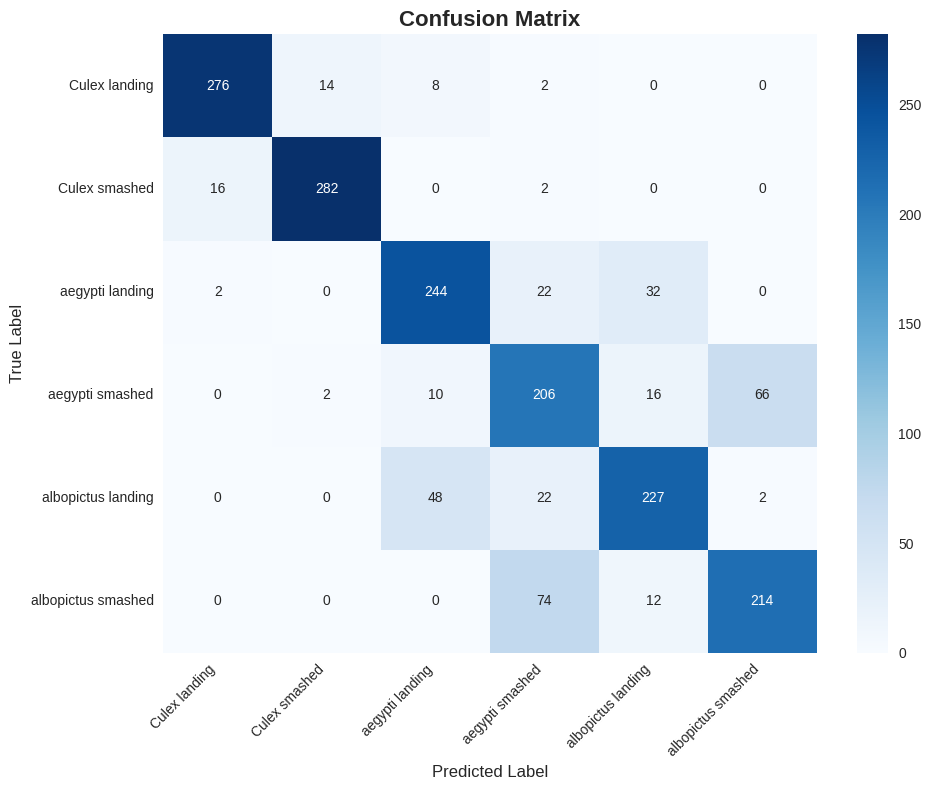

In [ ]:
confusion_matrix = plot_confusion_matrix(all_labels, all_predictions, testset.classes)

📈 Calculating per-class accuracy...

📊 Accuracy per class:
  Culex landing: 0.9200 (92.0%)
  Culex smashed: 0.9400 (94.0%)
  aegypti landing: 0.8133 (81.3%)
  aegypti smashed: 0.6867 (68.7%)
  albopictus landing: 0.7592 (75.9%)
  albopictus smashed: 0.7133 (71.3%)


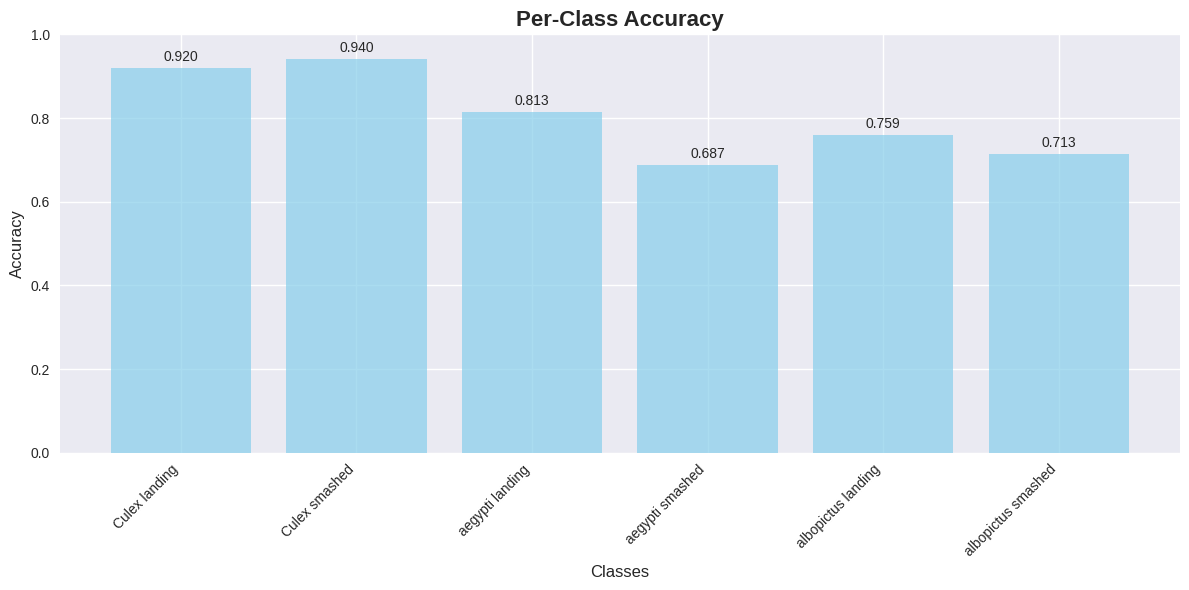

In [ ]:
# 3. calculate the accuracy for each class
per_class_accuracy = calculate_per_class_accuracy(all_labels, all_predictions, testset.classes)

🖼️ Displaying correctly classified samples (6 classes)


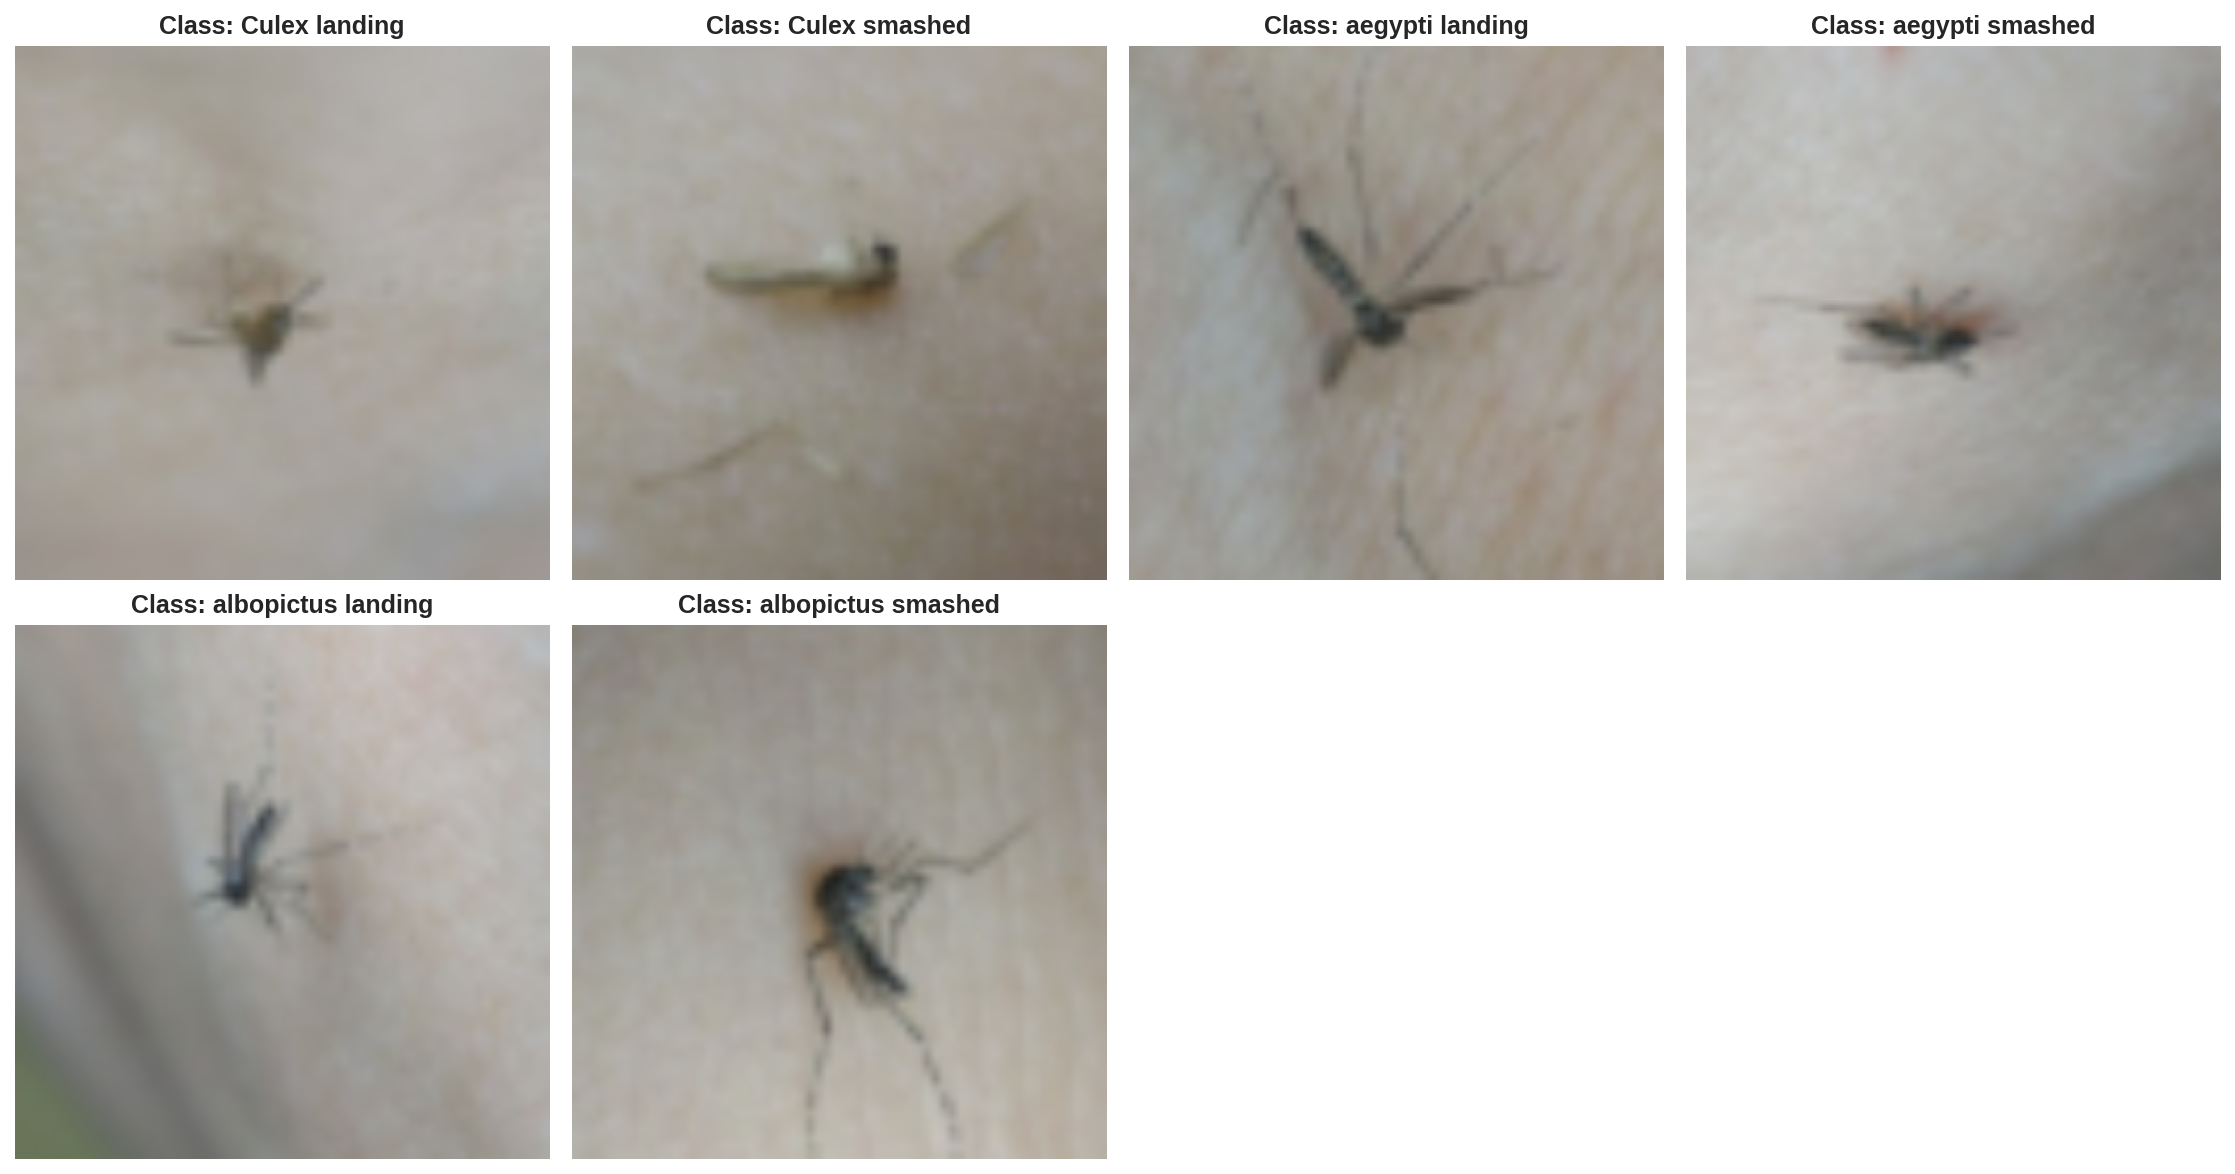

In [ ]:
#Displaying correctly classified samples
plot_correct_images(correct_images, testset.classes)

## **STEP6: Discussion**

### **Possible reasons of lower accuracy for the aegypti smashed class**
*   **Visual Similarity:** The aegypti smashed and albopictus smashed classes might have very similar features or patterns, making it harder for the CNN to distinguish between them.
*   **Feature Overlap:** The smashed state might cause overlapping features (damage patterns) that are common to both aegypti and albopictus, reducing class separability.
*   **Model Complexity:** The CNN architecture might not be complex enough to capture the subtle differences between these classes.

 <br>

### **Limitations**
*  **No Contextual Features:** The model only considers appearance, contextual cues (e.g., wing length or body texture under different lighting) are not used.

*  **No Spatial Attention:** The network does not focus on specific regions of interest, such as wings or thorax, which could help distinguish similar species.

*  **Data Augmentation Could Be Expanded:** More aggressive augmentation (zoom, brightness changes, background noise) might help the model generalize better to varied conditions.

 <br>

### **System Strengths**
**Efficient Architecture:**The model balances accuracy and computational efficiency with only three convolutional layers.

**Consistent Performance:** Most classes has consistent and good performance, with four out of six achieving near or above 80% accuracy.

**Balanced Dataset:** All class samples are well-distributed which ensures stable training and generalization.

 <br>

### **Possible Future Work**
**Use a Deeper CNN or Pretrained Model:** Introducing deeper networks (e.g., ResNet, MobileNet) or using pretrained models via transfer learning could help capture finer features.

**Add Attention Mechanisms:** Techniques like spatial or channel attention could help the network focus on key visual regions that differ between species.

**Enhance Data Diversity:** Attempt to Collecting more images under varied lighting, angles, and conditions — or using synthetic data — may help improve robustness.

